In [1]:
import numpy as np
import pandas as pd
import os
import pickle

import torch
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError

In [2]:
data_path = '/home/smart01/SFLAB/su_GTM_t/GTM_T_sanguk/'

meta_df = pd.read_csv(os.path.join(data_path,'240109_all_meta_sales_total.csv'))

with open(os.path.join(data_path, '12salesweek_test_item_number296.pkl'), 'rb') as f:
    test_ids = pickle.load(f)
test_ids = test_ids.drop('MTPT6102')

In [3]:
total_df = pd.DataFrame()
total_df['item_number'] = meta_df.loc[:, 'item_number']
total_df['sales_mean'] = meta_df.loc[:, 'sales_mean']
total_df['sales_std'] = meta_df.loc[:, 'sales_std']
total_df['fabric'] = meta_df.iloc[:, 4:9].idxmax(axis=1).apply(lambda x:x.split('_')[1])
total_df['category'] = meta_df.iloc[:, 9:14].idxmax(axis=1).apply(lambda x:x.split('_')[1])
total_df['color'] = meta_df.iloc[:, 14:27].idxmax(axis=1).apply(lambda x:x.split('_')[1])

In [4]:
train_df = total_df[~total_df['item_number'].isin(test_ids)] 
test_df = total_df[total_df['item_number'].isin(test_ids)]

In [5]:
smape = SymmetricMeanAbsolutePercentageError()

In [8]:
grouby_cols = ['color', 'category']
pred_df = test_df.copy()

train_mean = train_df.groupby(grouby_cols, as_index=False)['sales_mean'].mean()
train_mean.rename({'sales_mean':'train_mean'},axis=1, inplace=True)
pred_df = pd.merge(pred_df, train_mean, on=grouby_cols)

train_std = train_df.groupby(grouby_cols, as_index=False)['sales_std'].mean()
train_std.rename({'sales_std':'train_std'},axis=1, inplace=True)
pred_df = pd.merge(pred_df, train_std, on=grouby_cols)

In [9]:
mean_pred = torch.Tensor(pred_df['train_mean'])
mean_gt = torch.Tensor(pred_df['sales_mean'])

std_pred = torch.Tensor(pred_df['train_std'])
std_gt = torch.Tensor(pred_df['sales_std'])

ad_smape_mean = torch.mean(torch.stack([smape(mean_pred[i], mean_gt[i]) * 0.5 for i in range(len(mean_gt))]))
ad_smape_std = torch.mean(torch.stack([smape(std_pred[i], std_gt[i]) * 0.5 for i in range(len(std_gt))]))

ad_smape_mean, ad_smape_std

(tensor(0.3369), tensor(0.3616))

In [10]:
def smape(A, F):
    return 100 / len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape(pred_df['sales_mean'], pred_df['train_mean']), smape(pred_df['sales_std'], pred_df['train_std'])

(33.6928501901691, 36.162941046723084)

<Axes: ylabel='Frequency'>

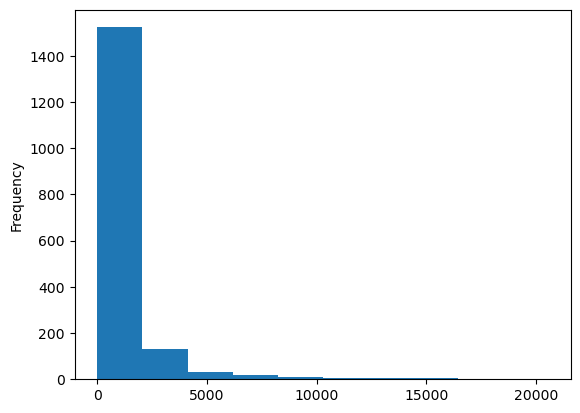

In [4]:
meta_df['sales_total'].plot.hist()

In [5]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [6]:
train_y, opt_lamda = boxcox(train_df['sales_total'])
train_df.loc[:,'boxcox_sales_total'] = train_y

/tmp/ipykernel_16130/2202484631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:,'boxcox_sales_total'] = train_y


<Axes: ylabel='Frequency'>

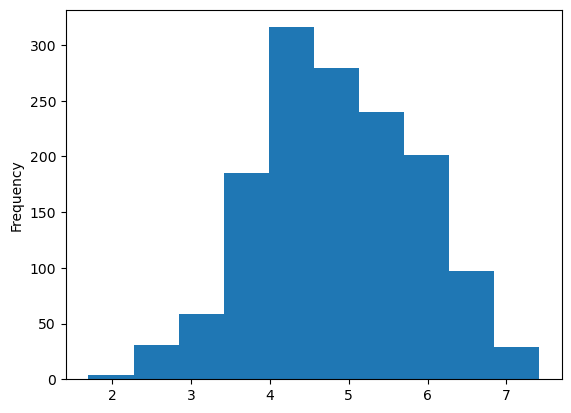

In [7]:
train_df['boxcox_sales_total'].plot.hist()

In [8]:
test_y = boxcox(test_df['sales_total'], opt_lamda)
test_df.loc[:,'boxcox_sales_total'] = test_y

/tmp/ipykernel_16130/1118741650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'boxcox_sales_total'] = test_y


<Axes: ylabel='Frequency'>

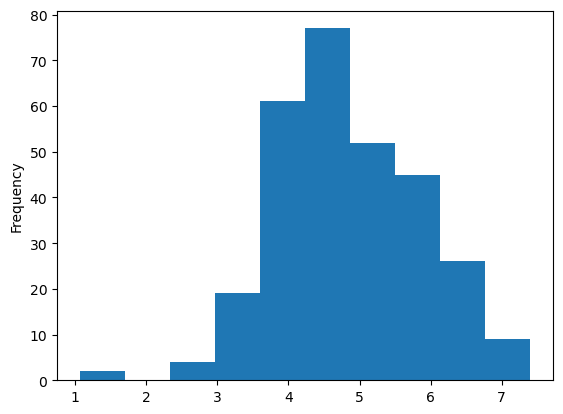

In [9]:
test_df['boxcox_sales_total'].plot.hist()

In [10]:
inv_boxcox(train_df['boxcox_sales_total'], opt_lamda)

0        58.0
1        70.0
2        74.0
3        13.0
4         6.0
        ...  
1731    788.0
1732    596.0
1733    158.0
1734    349.0
1735    264.0
Name: boxcox_sales_total, Length: 1441, dtype: float64

In [3]:
train_mm = pd.read_csv("/home/smart01/SFLAB/su_GTM_t/GTM_T_sanguk/meta_train_groupby_sales_mean_mean.csv")
train_sm = pd.read_csv("/home/smart01/SFLAB/su_GTM_t/GTM_T_sanguk/meta_train_groupby_sales_std_mean.csv")
test_mm = pd.read_csv("/home/smart01/SFLAB/su_GTM_t/GTM_T_sanguk/meta_test_groupby_sales_mean_mean.csv")
test_sm = pd.read_csv("/home/smart01/SFLAB/su_GTM_t/GTM_T_sanguk/meta_test_groupby_sales_std_mean.csv")

In [19]:
train_mm

,fabric,main_color,category,sales_mean
0,DENIM,BEIGE,DP,16.333333
1,DENIM,BLACK,DP,27.680556
2,DENIM,BLACK,OP,11.770833
3,DENIM,BLUE,DP,60.381757
4,DENIM,BLUE,HP,18.166667
...,...,...,...,...
62,WOVEN,YELLOW,OP,7.607143
63,특종,BEIGE,OP,6.083333
64,특종,BLACK,OP,11.500000
65,특종,GREEN,OP,11.750000


In [12]:
import matplotlib.pyplot as plt

/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


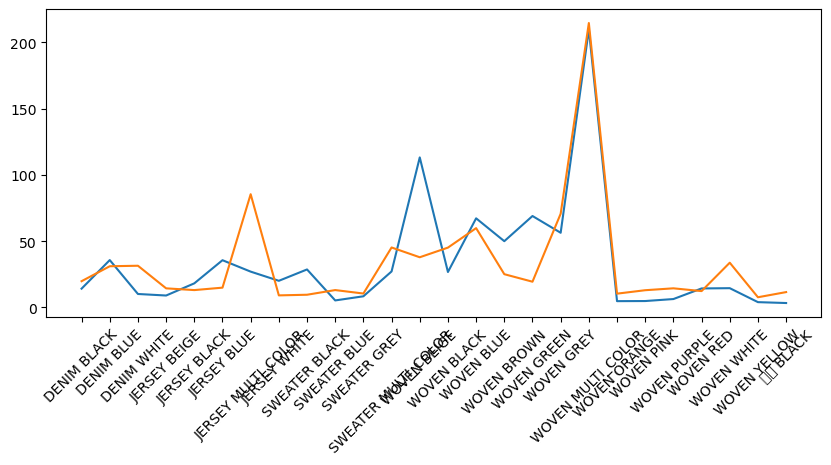

In [13]:
plt.figure(figsize=(10,4))

test_df = test_mm.groupby(['fabric', 'main_color'], as_index=False)['sales_mean'].mean()
test_df['new_col'] = test_df['fabric'] + ' ' +test_df['main_color'] 
train_df = train_mm.groupby(['fabric', 'main_color'], as_index=False)['sales_mean'].mean()
train_df['new_col'] = train_df['fabric'] + ' ' +train_df['main_color']


and_list = set(test_df['new_col']) & set(train_df['new_col'])
train_df = train_df[train_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)
test_df = test_df[test_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)

plt.plot(test_df['sales_mean'].values)
plt.plot(train_df['sales_mean'].values)

plt.xticks(train_df.index, train_df['new_col'].values,rotation=45)
plt.show()

/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


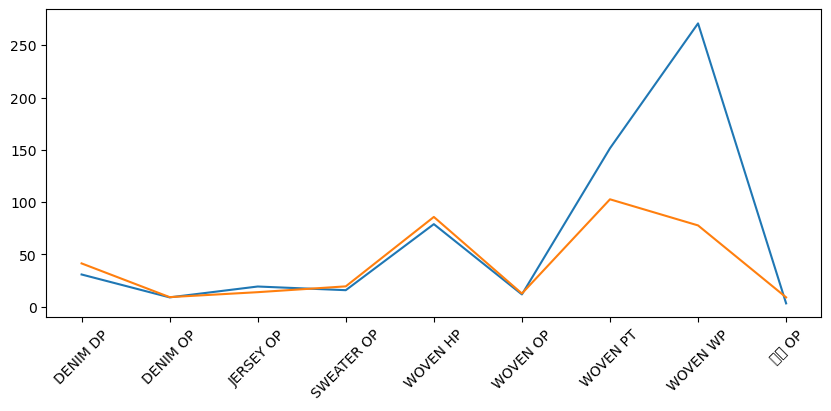

In [14]:
plt.figure(figsize=(10,4))

test_df = test_mm.groupby(['fabric', 'category'], as_index=False)['sales_mean'].mean()
test_df['new_col'] = test_df['fabric'] + ' ' +test_df['category'] 
train_df = train_mm.groupby(['fabric', 'category'], as_index=False)['sales_mean'].mean()
train_df['new_col'] = train_df['fabric'] + ' ' +train_df['category']


and_list = set(test_df['new_col']) & set(train_df['new_col'])
train_df = train_df[train_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)
test_df = test_df[test_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)

plt.plot(test_df['sales_mean'].values)
plt.plot(train_df['sales_mean'].values)

plt.xticks(train_df.index, train_df['new_col'].values,rotation=45)
plt.show()

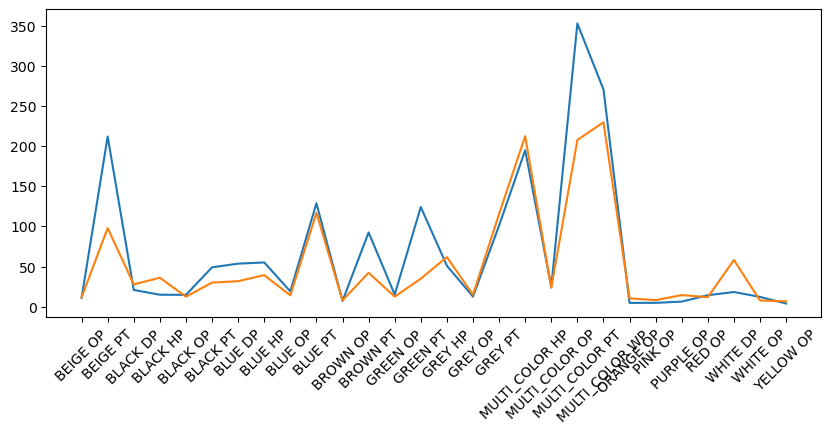

In [15]:
plt.figure(figsize=(10,4))

test_df = test_mm.groupby(['main_color', 'category'], as_index=False)['sales_mean'].mean()
test_df['new_col'] = test_df['main_color'] + ' ' +test_df['category'] 
train_df = train_mm.groupby(['main_color', 'category'], as_index=False)['sales_mean'].mean()
train_df['new_col'] = train_df['main_color'] + ' ' +train_df['category']


and_list = set(test_df['new_col']) & set(train_df['new_col'])
train_df = train_df[train_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)
test_df = test_df[test_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)

plt.plot(test_df['sales_mean'].values)
plt.plot(train_df['sales_mean'].values)

plt.xticks(train_df.index, train_df['new_col'].values,rotation=45)
plt.show()

/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


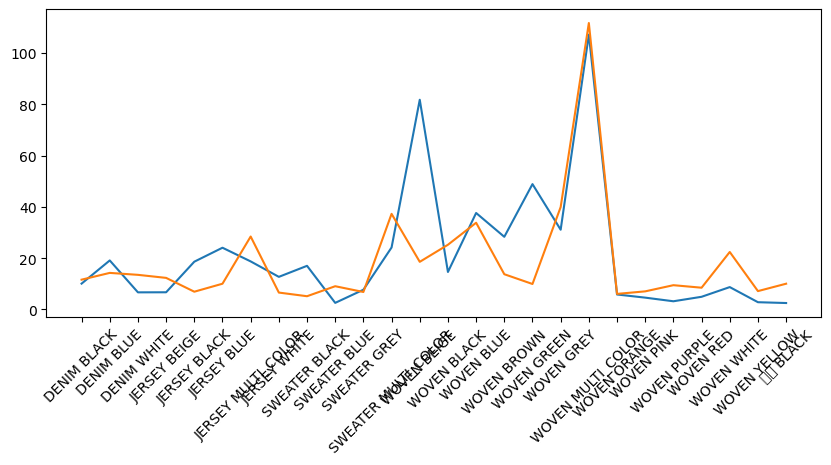

In [16]:
plt.figure(figsize=(10,4))

test_df = test_sm.groupby(['fabric', 'main_color'], as_index=False)['sales_std'].mean()
test_df['new_col'] = test_df['fabric'] + ' ' +test_df['main_color'] 
train_df = train_sm.groupby(['fabric', 'main_color'], as_index=False)['sales_std'].mean()
train_df['new_col'] = train_df['fabric'] + ' ' +train_df['main_color']


and_list = set(test_df['new_col']) & set(train_df['new_col'])
train_df = train_df[train_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)
test_df = test_df[test_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)

plt.plot(test_df['sales_std'].values)
plt.plot(train_df['sales_std'].values)

plt.xticks(train_df.index, train_df['new_col'].values,rotation=45)
plt.show()

/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


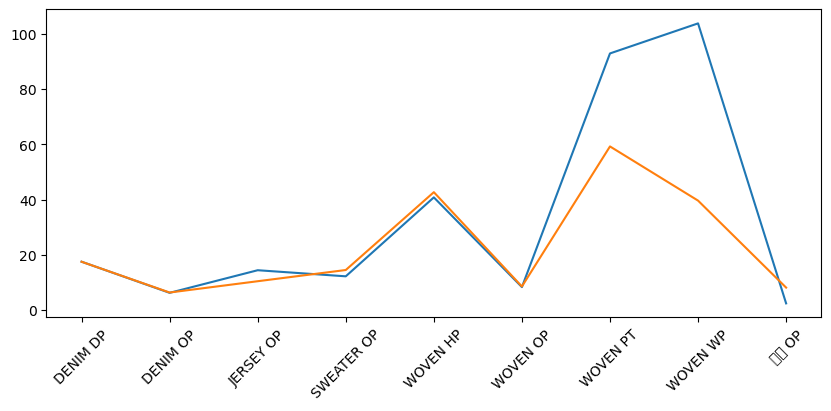

In [17]:
plt.figure(figsize=(10,4))

test_df = test_sm.groupby(['fabric', 'category'], as_index=False)['sales_std'].mean()
test_df['new_col'] = test_df['fabric'] + ' ' +test_df['category'] 
train_df = train_sm.groupby(['fabric', 'category'], as_index=False)['sales_std'].mean()
train_df['new_col'] = train_df['fabric'] + ' ' +train_df['category']


and_list = set(test_df['new_col']) & set(train_df['new_col'])
train_df = train_df[train_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)
test_df = test_df[test_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)

plt.plot(test_df['sales_std'].values)
plt.plot(train_df['sales_std'].values)

plt.xticks(train_df.index, train_df['new_col'].values,rotation=45)
plt.show()

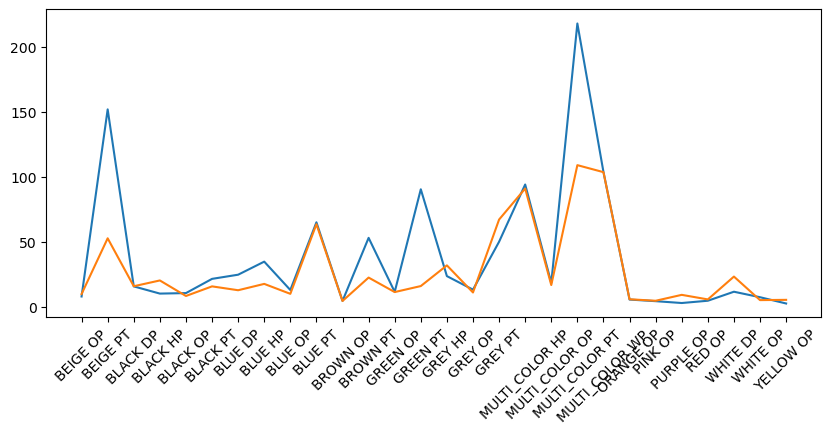

In [18]:
plt.figure(figsize=(10,4))

test_df = test_sm.groupby(['main_color', 'category'], as_index=False)['sales_std'].mean()
test_df['new_col'] = test_df['main_color'] + ' ' +test_df['category'] 
train_df = train_sm.groupby(['main_color', 'category'], as_index=False)['sales_std'].mean()
train_df['new_col'] = train_df['main_color'] + ' ' +train_df['category']


and_list = set(test_df['new_col']) & set(train_df['new_col'])
train_df = train_df[train_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)
test_df = test_df[test_df['new_col'].isin(and_list)].sort_values('new_col').reset_index(drop=True)

plt.plot(test_df['sales_std'].values)
plt.plot(train_df['sales_std'].values)

plt.xticks(train_df.index, train_df['new_col'].values,rotation=45)
plt.show()